# WATExR: comparing System5 and ERA5 using tercile plots

This notebook performs basic validation of the seasonal forecast output by creating tercile plots. The code is modified from the original [here](https://github.com/icra/WATExR/blob/master/R/validation.R).

In [1]:
# Load packages. 
library(transformeR)
library(visualizeR)
library(Cairo)
library(abind)


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 1.7.3 (2020-02-28) is loaded

Please see 'citation("transformeR")' to cite this package.

Warning message:
“no DISPLAY variable so Tk is not available”
visualizeR version 1.5.1 (2020-01-05) is loaded

Please see 'citation("visualizeR")' to cite this package.



## 1. User settings

In [2]:
# Output path where the generated validation plots will be saved
dir.validation <- '../tercile_plots_stats/System5_vs_ERA5/'

# Path where Rdata was saved
dir.Rdata <- '../../Data/Meteorological/RData/'

# Choose season ('spring', 'early_summer', 'late_summer', 'winter')
season_name <- 'winter'

# Choose months for sub-setting (either NULL or list of months)
months <- NULL

# Choose model ('gotm', 'bayes_net')
model <- 'bayes_net'

# Select variables for validation
variables <- c('psl', 'tcc', 'uas', 'vas', 'tas', 'tdps', 'rsds', 'rlds', 'tp')

## 2. Load data

In [3]:
# Load ERA5
obs.data <- get(load("../../Data/Meteorological/RData/era5_morsa_1980-2019_daily.rda"))

# Load S5
forecast.data <- get(load(sprintf("../../Data/Meteorological/RData/s5_morsa_%s_merged_%s_bc.rda", model, season_name))) 

## 3. Intersect grids

pad applied on the interval: day

pad applied on the interval: day



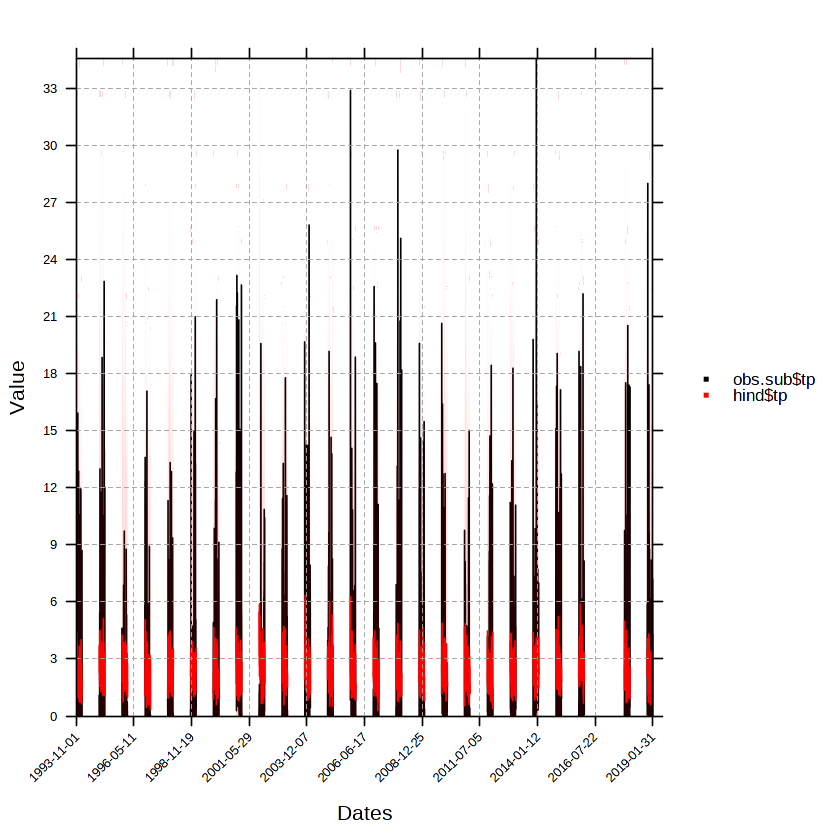

In [4]:
# Retain required variables
ind <- abind(lapply(variables, function(x) which(names(obs.data) == x)))
obs <- obs.data[ind]
ind <- abind(lapply(variables, function(x) which(names(forecast.data) == x)))
hind <- forecast.data[ind]

if (!identical(names(obs), names(hind))) stop("there is one or more variables missing in the observations and/or forecast data.")

# If specified, subset the S5 data to only the specified months                    
if (!is.null(months)) { 
    hind <- lapply(variables, function(x) {subsetGrid(hind[[x]], season=months)})
}
                           
# Subset ERA5 to match S5
obs.sub <- lapply(1:length(obs), function(x) {intersectGrid(obs[[x]], hind[[x]], type = "temporal", which.return = 1)})
hind <- lapply(1:length(obs), function(x) {intersectGrid(obs[[x]], hind[[x]], type = "temporal", which.return = 2)})

names(obs.sub) <- sapply(obs.sub, function(x) getVarNames(x))
names(hind) <- sapply(hind, function(x) getVarNames(x))

# Plot time series
temporalPlot(obs.sub$tp, hind$tp)

## 4. Tercile plots

In [5]:
# Create and save tercile plots
for (i in 1:length(variables)) {
    if (is.null(months)) { 
        filename <- paste0(dir.validation, 'morsa_', model, "_", season_name, "_", variables[i], ".pdf") 
    } else {
        filename <- paste0(dir.validation, 'morsa_', model, "_", season_name, "_months", 
                           paste0(months[1], '-', months[length(months)]), '_', variables[i], ".pdf")
    }    
    CairoPDF(file = filename, width = 10)
    tercilePlot(obs = redim(obs.sub[[i]]), hindcast = redim(hind[[i]]))
    dev.off()   
}

## 5. Save ROCSS to CSV

The code below is horribly hacked from the source for the `tercilePlot` function here:

    https://rdrr.io/github/SantanderMetGroup/visualizeR/src/R/tercilePlot.R

In [6]:
# Containers for data
par <- c()
terc <- c()
roc <- c()
sig <- c()

# Loop over vars
for (i in 1:length(variables)) {
    obs <- redim(obs.sub[[i]])
    hindcast <- redim(hind[[i]])
    
    # Check data dimension from the original data sets
    checkDim(hindcast)
    checkDim(obs)

    # Check input datasets
    if (isS4(hindcast)==FALSE){
      hindcast <- visualizeR:::convertIntoS4(hindcast)
    }
    if (isS4(obs)==FALSE){
      obs <- visualizeR:::convertIntoS4(obs)
    }
    stopifnot(visualizeR:::checkData(hindcast, obs))

    # Spatial mean of forecast and Benchmark if necessary
    sp.hindcast <- spatialMean(hindcast)
    sp.obs <- spatialMean(obs)
    
    # Computation of seasonal mean
    sm.hindcast <- seasMean(sp.hindcast)
    sm.obs <- seasMean(sp.obs)
    
    # Computation of terciles and exceedance probabilities
    probs.hindcast <- QuantileProbs(sm.hindcast)
    probs.obs <- QuantileProbs(sm.obs)
    cofinogram.data <- t(visualizeR:::getData(probs.hindcast)[,,,,])
    obs.terciles <- t(visualizeR:::getData(probs.obs)[,,,,])
    obs.t <- visualizeR:::getData(probs.obs)[3,,,,]-visualizeR:::getData(probs.obs)[1,,,,]
    
    # Compute ROCSS
    rocss.t.u <- rocss.fun(obs.terciles[,3], cofinogram.data[,3], 0.95)
    rocss.t.m <- rocss.fun(obs.terciles[,2], cofinogram.data[,2], 0.95)
    rocss.t.l <- rocss.fun(obs.terciles[,1], cofinogram.data[,1], 0.95)
    
    # Build df
    terc_names <- c('lower', 'middle', 'upper')
    rocss_list = c(rocss.t.l$score.val, rocss.t.m$score.val, rocss.t.u$score.val)
    sig_list = c(rocss.t.l$sig, rocss.t.m$sig, rocss.t.u$sig)
    for (j in 1:length(terc_names)) {
        par[[i*3 + j - 2]] <- variables[i] 
        terc[[i*3 + j - 2]] <- terc_names[j] 
        roc[[i*3 + j - 2]] <- rocss_list[j]
        sig[[i*3 + j - 2]] <- sig_list[j] 
    }  
}

df <- na.omit(data.frame(par, terc, roc, sig))

if (is.null(months)) { 
    filename <- paste0(dir.validation, 'morsa_', model, "_", season_name, "_rocss.csv") 
} else {
    filename <- paste0(dir.validation, 'morsa_', model, "_", season_name, "_months", 
                       paste0(months[1], '-', months[length(months)]), "_rocss.csv")
}

write.csv(df, file = filename, row.names = FALSE) 

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specified dimensions do not exist in the grid

NOTE: Some of the specifi